In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from scipy import stats
import scipy as sp
import datetime as dt

from ei_net import * 
from ce_net import * 
from utilities import show_values

import cmocean as cmo

%matplotlib inline

# Uncertainty and causal emergence in complex networks

In [2]:
##########################################
############ PLOTTING SETUP ##############
EI_cmap = "Greys"
where_to_save_pngs = "../figs/pngs/"
where_to_save_pdfs = "../figs/pdfs/"
save = True
plt.rc('axes', axisbelow=True)
# plt.rc('text', usetex=True)
# plt.rc('axes', linewidth=2)
# hfont = {'fontname':'Helvetica'}
# plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
##########################################
##########################################

# Chapter 05 - Causal Emergence in Preferential Attachment and SBMs

## Effective Information at the Macro Scale
This new global network measure, $EI$, offers a principled way to ask important questions for studying systems in general: what is the most suitable model that accurately captures the information about causation in a system? What representation will minimize the noise present in a network?

Science analyzes the causal structure of different systems at different spatiotemporal scales, often preferring to intervene and observe certain systems at levels far above that of the microscale (Hoel, 2018). This presents a problem  or paradox, a fact long highlighted in analytic philosophy (Fodor, 1974; Kim, 2000). To state the issue mathematically: it seems impossible to gain information by reducing the dimensionality of a system (via a macro-scale like a coarse-grain). Such macro-scales seem to be definitionally throwing information away. While there have been many attempts to circumnavigate this issue in a scientific manner (Anderson, 1972; Campbell, 1974; Bunge, 1963; Sperry, 1969), the more qualitative approaches have implicitly concluded that at best a macro-scale can be lossless and preserve micro-scale dynamics successfully (Crutchfield, 1994; Wolpert, Grochow, Libby, & DeDeo, 2014).

What has been often overlooked is the role of noise in causal relationships. Causal relationships at the micro-scale can be extremely noisy and therefore uninformative, and coarse-graining can minimize thisn oise (Hoel et al., 2013).  Indeed, this causal emergence is actually grounded in Claude Shannon’s noisy-channel coding theorem (Hoel, 2017; Shannon, 1948), and dimensional reductions operate like codes that usemore of a channel’s capacity. Ultimately it reveals that sometimes higher-level causal relationships performerror correction on the lower-level relationships, thus generating extra information at those higher scales by combating noise. Measuring this difference provides a principled means of deciding when higher-scales aremore informative (emergence) vs when higher scales are extraneous, epiphenomenal, or lossy (reduction).

In a network approach to causal structure, causal emergence is when a dimensionally-reduced network is actually more informative. That is, it is possible to recast a network, $G_0$, into a new, coarse-grained network, $G_m$, consisting of *micro-nodes*, *macro-nodes*, and the edges between them. In $G_m$, a micro-node is a node that was present in the original $G_0$, and a macro-node is defined as a $\text{node}_i$ that represents a subgraph, $S_i$, in the original $G_0$ such that $N_{G_0} > N_{G_m}$. Causal emergence occurs if such a recast network, $G_m$, has more $EI$ than the original network, $G_0$, with all of its nodes and edges. 

Figure 5 below shows a trivial example of both emergence and reduction in two simple systems. The first (top row) is composed of binary *copy*-gates (the state of one node is copied by the other node), while the second is composed of *and*-gates (the states of both nodes determine the subsequent state of one node). In the final column of Figure 5, the first system is shown to be an example of causal reduction is shown (top row) while the second is an example of causal emergence (bottom row). All possible coarse-grained networks were searched to find the network with maximal $EI$ in each system.

_____________________________________________

## Causal Communities
Applying such an analysis to complex networks would be useful in improving scientific experimental design, the compression and search of big data, model choice, and even machine learning. However, one issue is the combinatorially vast space of possible coarse-grained networks, especially in large networks, as real network datasets often are. While only a small fraction of coarse-grained networks contain more $EI$ than the original network, finding a maximum is been a computational bottleneck for all but the smallest networks. However, there are useful heuristics for implementing this coarse-graining process. In this notebook, we show several example methods for coarse-graining a given network (in this case, a Barabási-Albert Network where $N=200$, $m=2$). In both cases, we create macro-nodes by pairing two nodes in the network together, grouping them into a single node. If this operation increases the $EI$ in the network, then causal emergence is the amount of $EI$ gained through that coarse-graining. Grouping pairs of nodes in a network is relatively cheap computationally, but grouping three nodes into a macro-node increases the search space enormously (as does four-node groupings, etc.). In further research, we intend to develop efficient ways to group more than two nodes at a time.

Fundamentally, this process of iteratively creating macro-nodes can be interpreted as discovering \textit{causal communities} in a given network. Indeed, we define a causal community as any set of nodes that shares overlap in their inputs and outputs such that when grouped into a macro-node, the resulting network $G_m$ has a higher $EI$ than the original network, $G_0$. It follows that only groupings that reduce the entropy of $W_{i}^{out}$ or increase the entropy of $W_{in}$ will be causal communities. Similarly if you group over anything that is *not* a causal community, you will either increase your degeneracy or decrease you determinism, thus decreasing the $EI$. 

Finally, by defining a causal community in a network, we are able to make an observation about the (micro-) nodes that constitute the causal community: namely, all causal communities represent noise at the micro-level, and we can minimize the noise in a given network by creating macro-nodes, thereby defining a more optimal scale to represent using a given network.
_____________________________________________
<img src="../figs/pngs/CausalEmergence_from_CausalModel.png">

Figure 5: **The presence and absence of higher-scale causation in two simple causal structures.** Two systems, a *copy*-gate (top row) and an *and*-gate (bottom row), their associated transition probability matrices, the network formed if the transition probability matrix were an adjacency matrix, and the same higher scale representation of each network. Representing the *copy* system with a macro-node loses 1 bit of $EI$, while representing the *and* system in the same way leads to an increase of 0.17 bits.

In [109]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

## 5.1 Stochastic block models and causal emergence

In [271]:
N = 100
n_times = int(N/10)
ranges = np.arange(3, int(N/2)+1, 1, dtype=int)

out_ei = []
out_pi = []
out_ss = []
out_ce = []
out_sd = []
pin_probs = np.linspace(0, 1, len(ranges))
pin_probs = sorted(np.unique(list(  np.logspace(-2,0,len(ranges)/2-1)*0.5) + \
                             list(1-np.logspace(-2,0,len(ranges)/2-1)*0.5)))
pin_probs.append(0.0)
pin_probs.append(1.0)
pin_probs = sorted(pin_probs)

In [272]:
out_df = pd.DataFrame(columns=['p_in', 'sizes', 'iter', 'ce'])
test_out_pfrac = []
test_out_asymm = []
test_out_causa = []

for i in ranges:
    print("Starting iteration %02i at %s"%(i, dt.datetime.now()))
    sizes = [N-i, i]
    macros = [0]*sizes[0] + [1]*sizes[1]
    for p_in in pin_probs:
        out_ei_i = []
        out_pi_i = []
        out_ss_i = []
        out_ce_i = []
        p_ex = 1-p_in
        
        for nn in range(n_times):
            edge_left = 0
            dat = {'p_in':[p_in], 'sizes':[sizes[0]/N], 'iter':[nn]}
            G = nx.DiGraph()
            G.add_nodes_from(list(range(sum(sizes))))
            nx.set_node_attributes(G, dict(zip(G.nodes(),list(np.array(macros)+N))), 'macro')
            
            probs = [p_in]*sizes[0] + [p_ex]*sizes[1]
            for node_i in list(G.nodes())[:sizes[0]]:
                for node_j in list(G.nodes()):
                    if np.random.rand() < probs[node_j] and node_i!=node_j:
                        G.add_edge(node_i, node_j)
                        edge_left += 1
                        

            probs = [p_ex]*sizes[0] + [p_in]*sizes[1]
            for node_i in list(G.nodes())[sizes[0]:]:
                for node_j in list(G.nodes()):
                    if np.random.rand() < probs[node_j] and node_i!=node_j:
                        G.add_edge(node_i, node_j)

            test_out_pfrac.append(edge_left/G.number_of_edges())
            test_out_asymm.append((N-i)/N)
                        
            current_ei = EI(G)
            macro_types = {N:'spatem1',N+1:'spatem1'}
            mac_map = nx.get_node_attributes(G, 'macro')
            mG = MACRO(G, mac_map,macro_types)
            macro_ei = EI(mG)
            dat['ce'] = [current_ei-macro_ei]
            test_out_causa.append(current_ei-macro_ei)
            
            out_df = out_df.append(pd.DataFrame(dat))

Starting iteration 03 at 2019-05-21 12:47:28.660538
Starting iteration 04 at 2019-05-21 12:48:16.688015
Starting iteration 05 at 2019-05-21 12:49:06.864756
Starting iteration 06 at 2019-05-21 12:49:55.510193
Starting iteration 07 at 2019-05-21 12:50:47.422753
Starting iteration 08 at 2019-05-21 12:51:38.631042
Starting iteration 09 at 2019-05-21 12:52:29.724818
Starting iteration 10 at 2019-05-21 12:53:18.240086
Starting iteration 11 at 2019-05-21 12:54:07.471655
Starting iteration 12 at 2019-05-21 12:54:58.083182
Starting iteration 13 at 2019-05-21 12:55:47.742643
Starting iteration 14 at 2019-05-21 12:56:37.843428
Starting iteration 15 at 2019-05-21 12:57:27.340195
Starting iteration 16 at 2019-05-21 12:58:18.171461
Starting iteration 17 at 2019-05-21 12:59:10.153300
Starting iteration 18 at 2019-05-21 13:00:02.169726
Starting iteration 19 at 2019-05-21 13:00:58.221389
Starting iteration 20 at 2019-05-21 13:01:50.530607
Starting iteration 21 at 2019-05-21 13:02:45.746863
Starting ite

In [11]:
from itertools import groupby
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [20]:
def get_pos(N, size_dist):
    """Arranges the graphs nicely"""
    pos = {}
    chunk_dict, node_chunk_dict = get_chunksize_dict(N, size_dist)
    ii = 0
    for chunk, nodes in sorted(chunk_dict.items(), key=lambda kv: kv[1][0], reverse=True):
        frac_nodes = N/len(nodes)
        G = nx.complete_graph(len(nodes))
        posi = nx.spring_layout(G)
        posi = dict(zip(nodes, (np.array(list(posi.values()))/frac_nodes + np.array([1.5*ii,0]))))
        pos.update(posi)
        ii += 1
                
    return pos

def get_chunksize_dict(N, size_dist):
    """Returns an array of size_dist-distributed chunks for your network"""
    chunksize_dist = np.array(size_dist)
    chunksize_dist = sorted(chunksize_dist, reverse=True)
    chunksizes = np.array(N*(chunksize_dist/sum(chunksize_dist)), dtype=int)
    diff_size_check = int(N - sum(chunksizes))
    if diff_size_check > 0:
        for i in range(diff_size_check):
            chunksizes[0] += 1
    if diff_size_check < 0:
        for i in range(np.abs(diff_size_check)):
            chunksizes[0] -= 1

    for i in range(len(chunksizes)):
        if chunksizes[i] == 0:
            chunksizes[0] -= 2
            chunksizes[i] += 2

        if chunksizes[i] == 1:
            chunksizes[0] -= 1
            chunksizes[i] += 1    

    chunk_dict = {}
    curr = 0
    for i in range(len(chunksizes)):
        nums = list(range(curr, curr+chunksizes[i]))
        chunk_dict[i] = nums
        curr = nums[-1]+1
    
    node_chunks_dict = {}
    for k in chunk_dict.keys():
        for i in chunk_dict[k]:
            node_chunks_dict[i] = k
    
    return chunk_dict, node_chunks_dict


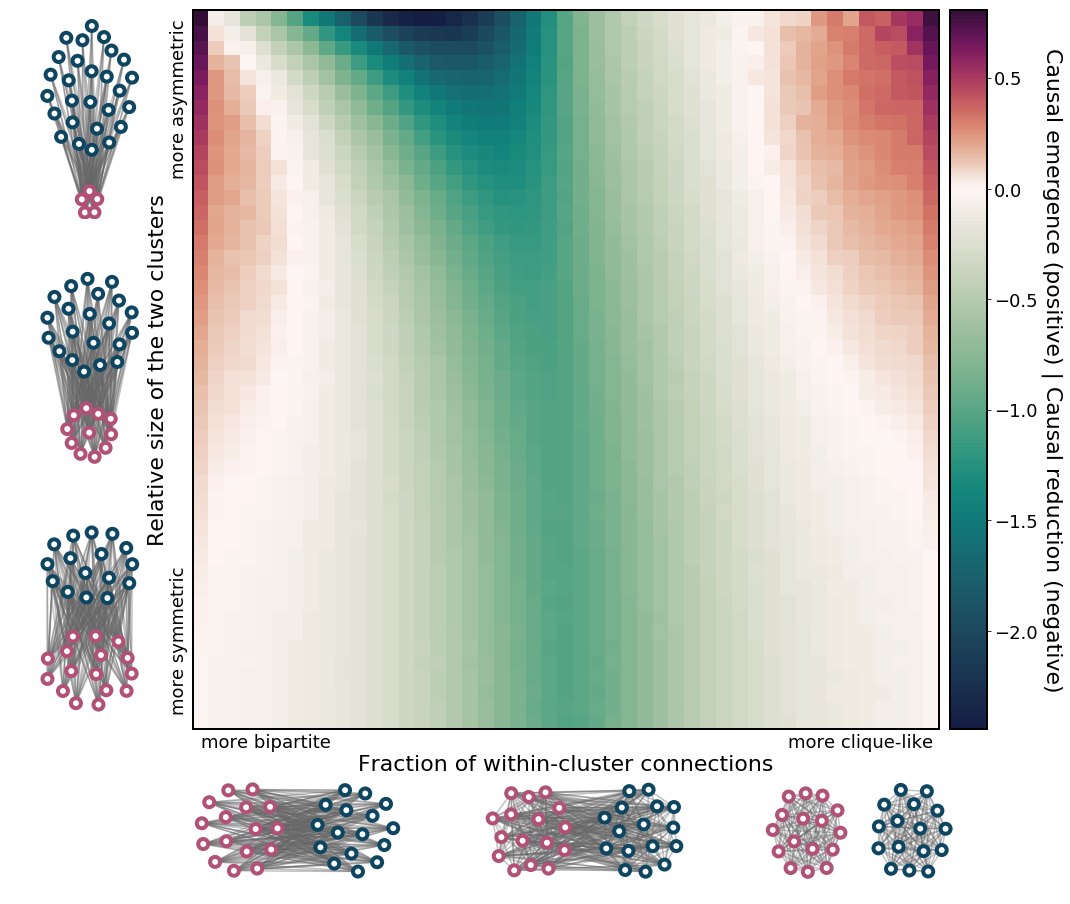

In [291]:
from matplotlib import gridspec
ew = 2.5
fig, ax = plt.subplots(1,1,figsize=(17,16))
plt.subplots_adjust(wspace=0.25, hspace=0.25)

gs = gridspec.GridSpec(4, 4, height_ratios=[1,1,1,0.5], width_ratios=[0.45,1,1,1])
ax0 = plt.subplot(gs[0:3, 1:4])

imsho_ce = imsho_ce*(-1)
plt.rc('axes', linewidth=2)
################################################################
imsho_ce = np.array(out_df.groupby(['p_in','sizes'])['ce'].
                    mean()).reshape((len(pin_probs), len(ranges))).T
imsho_sd = np.array(out_df.groupby(['p_in','sizes'])['ce'].
                    var()).reshape((len(pin_probs), len(ranges))).T
imsho_ma = np.array(out_df.groupby(['p_in','sizes'])['ce'].
                    max()).reshape((len(pin_probs), len(ranges))).T
imsho_mi = np.array(out_df.groupby(['p_in','sizes'])['ce'].
                    min()).reshape((len(pin_probs), len(ranges))).T
imsho_ce = imsho_ce*(-1)
maxval_ce = max(imsho_ce.flatten())
minval_ce = min(imsho_ce.flatten())

maxval_sd = max(imsho_sd.flatten())
minval_sd = min(imsho_sd.flatten())
maxval_ma = max(imsho_ma.flatten())
minval_ma = min(imsho_ma.flatten())
maxval_mi = max(imsho_mi.flatten())
minval_mi = min(imsho_mi.flatten())
xtix = pin_probs
ytix = (N-np.array(sorted(ranges, reverse=True)))/N
xlab = "Fraction of within-cluster connections"
ylab = "Relative size of the two clusters"
cba0 = "Causal emergence (positive) | Causal reduction (negative)"
cba1 = "Variance of Micro EI - Macro EI"
cba2 = "Maximum of Micro EI - Macro EI"
cba3 = "Minimum of Micro EI - Macro EI"
colm = cmo.cm.curl
tit0 = "Stochastic Block Models and Causal Emergence\n N = %i, n_iter = %i"%(N,n_times)

xtl = ['']*4+ ['more bipartite'] + [""]*(len(xtix)-12)+ ['more clique-like'] + ['']*7
ytl = ['']*8+ ['more symmetric'] + [""]*(len(ytix)-12)+ ['more asymmetric']  + ['']

ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_xlabel(xlab, size=22, labelpad=25.0)
ax0.set_ylabel(ylab, size=22, labelpad=25.0)
ax0.text(0.5, -1.2, 'more bipartite', fontsize=18)
ax0.text(imsho_ce.shape[1]-9.5, -1.2, 'more clique-like', fontsize=18)

ax0.text(-1.4, 10.0, 'more symmetric', fontsize=18, rotation=90)
ax0.text(-1.4, imsho_ce.shape[0]-1.5, 'more asymmetric', fontsize=18, rotation=90)

im_ce = ax0.pcolor(imsho_ce, cmap=colm, clim=(minval_ce, maxval_ce), 
                   norm=MidpointNormalize(midpoint=0, vmin=minval_ce, vmax=maxval_ce))
divider=make_axes_locatable(ax0); cax=divider.append_axes("right", size="5%", pad=0.15)
cb = plt.colorbar(im_ce, cax=cax)
cb.set_label(cba0, fontsize=22, rotation=270, labelpad=25.0)
cb.ax.tick_params(labelsize=18) 

ns = 100
for q, Q in enumerate(nets[:3]):
    g = Q[0]
    sizes = Q[2]
    N = Q[1]
    ax0 = plt.subplot(gs[-1, q+1])
    pos = get_pos(N, sizes)
    nodecols = Q[3]
    nx.draw_networkx_nodes(g, pos, node_size=ns, linewidths=4.0, node_color='w').set_edgecolor(nodecols)
    nx.draw_networkx_edges(g, pos, edge_color='#666666', width=1.5, alpha=0.4)

    ax0.set_axis_off()
    posy = np.array(list(zip(*list(pos.values())))[1])
    posx = np.array(list(zip(*list(pos.values())))[0])
    ax0.set_ylim(min(posy)*1.2, max(posy)*1.35)
    if q==0:
        ax0.set_xlim(min(posx)*1.25, max(posx)*1.2)
    if q==1:
        ax0.set_xlim(min(posx)*1.5, max(posx)*1.2)
    if q==2:
        ax0.set_xlim(min(posx)*1.5, max(posx)*1.3)

for q, Q in enumerate([nets[6],nets[3],nets[0]]):
    g = Q[0]
    sizes = Q[2]
    N = Q[1]
    ax0 = plt.subplot(gs[q, 0])
    pos = get_pos(N, sizes)
    pos = {i:(k[1],k[0]) for i,k in pos.items()}
    nodecols = Q[3]
    nx.draw_networkx_nodes(g, pos, node_size=ns, linewidths=4.0, node_color='w').set_edgecolor(nodecols)
    nx.draw_networkx_edges(g, pos, edge_color='#666666', width=1.5, alpha=0.4)

    ax0.set_axis_off()
    posy = np.array(list(zip(*list(pos.values())))[1])
    posx = np.array(list(zip(*list(pos.values())))[0])
    ax0.set_xlim(min(posx)*1.21, max(posx)*1.25)
    ax0.set_ylim(min(posy)*1.71, max(posy)*1.09)

if save:
    plt.savefig(where_to_save_pngs+"CausalEmergence_SBM_mean_N100c_wNets.png", bbox_inches='tight', dpi=425)
    plt.savefig(where_to_save_pdfs+"CausalEmergence_SBM_mean_N100c_wNets.pdf", bbox_inches='tight')

plt.show()

___________________

## 5.2 Causal emergence in preferential attachment networks

In [5]:
def preferential_attachment_network(N, alpha=1.0, m=1):
    """
    sublinear, linear, or superlinear preferential attachment
    """
    G = nx.Graph()
    G.add_edge(0,1)
    for node_i in range(2,N):
        degrees = np.array(list(dict(G.degree()).values()))
        probs = (degrees**alpha) / sum(degrees**alpha)
        eijs = np.random.choice(G.number_of_nodes(), size=(m,), replace=False, p=probs)
        for node_j in eijs:
            G.add_edge(node_i, node_j)
    
    return G

In [25]:
min_alpha = 0
max_alpha = 2
min_N = 10
max_N = 200

m = 1

num_i = 20
num_N = 100
num_a = 9

alphas = np.linspace(min_alpha, max_alpha, num_a)
pa_alpha = {}

In [ ]:
for alpha in alphas:
    pa_ce = {}
    Ns = np.random.choice(list(range(min_N, max_N)), size=num_N, replace=False)
    print("Starting iteration alpha = %.2f at %s"%(alpha, dt.datetime.now()))
    for N in Ns:
        pa_tr1 = []
        for i in range(num_i):
            try:
                CE = CAUSAL_EMERGENCE(preferential_attachment_network(N, alpha, m), printt=False)
                mG = CHECK_NETWORK(CE['G_macro'])
                if CE['EI_macro'] > CE['EI_micro']:
                    pa_tr1.append(mG.number_of_nodes())

            except:
                continue
              
        pa_ce[N] = pa_tr1
    
    pa_alpha[alpha] = pa_ce

Starting iteration alpha = 0.00 at 2019-04-04 16:15:12.854888


In [ ]:
out_df = pd.DataFrame(columns=['alpha', 'ce_size'])

for alpha in pa_alpha.keys():
    curr = pa_alpha[alpha]
    for Nmicro in curr.keys():
        Nmacro_list = curr[Nmicro]
        for Nmacro in Nmacro_list:
            dat = {'alpha':[alpha], 'ce_size':[Nmacro/Nmicro]}
            out_df = out_df.append(pd.DataFrame(dat))
            
out_df.groupby('alpha').mean()

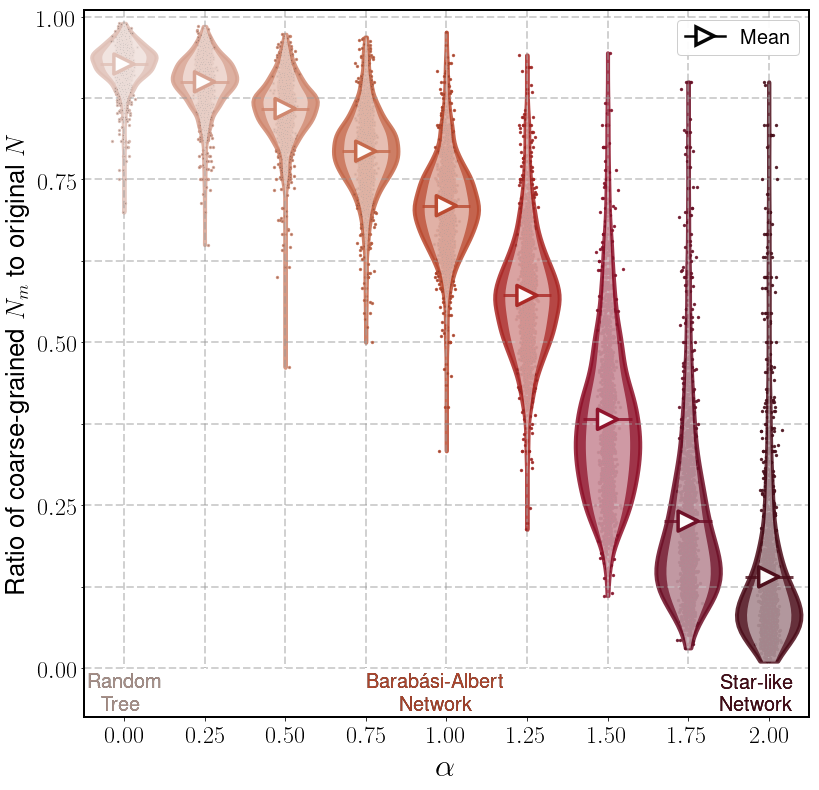

In [58]:
plt.rc('axes', axisbelow=True)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 13))

# cols = cmo.cm.amp(np.linspace(0.15,0.95,len(alphas)))
cols = plt.cm.viridis(np.linspace(0.15,0.95,len(alphas)))


for i in range(len(alphas)):
    alpha = alphas[i]
    dat = out_df[out_df['alpha']==alpha]
    raw = np.array(list(dat['ce_size']))
    
    parts = ax.violinplot(dat['ce_size'], positions=[i+1], showmeans=False, 
                          showmedians=False, showextrema=False, widths=0.8)
    pc = parts['bodies'][0]
    pc.set_edgecolor(cols[i])
    pc.set_facecolor(cols[i])
    pc.set_alpha(0.85)
    pc.set_linewidth(4.0)
    pc.set_zorder(0)

    plt.plot([i+1]*len(raw)+np.random.normal(0,0.045,len(raw)),raw,
             marker='.',linestyle='', markeredgecolor=cols[i], markeredgewidth=1.35,
             markersize=4.0, color='#333333', alpha=0.85, zorder=1)
    
    parts = ax.violinplot(dat['ce_size'], positions=[i+1], showmeans=False, 
                          showmedians=False, showextrema=False, widths=0.55)
    pc = parts['bodies'][0]
    pc.set_edgecolor(cols[i])
    pc.set_facecolor('w')
    pc.set_alpha(0.5)
    pc.set_linewidth(0.0)
    pc.set_zorder(2)
    
    
plt.hlines(list(out_df.groupby('alpha').mean()['ce_size']), 
           np.linspace(0.7, 8.7, 9), np.linspace(1.3, 9.3, 9), 
           colors=cols, linewidth=3, alpha=0.8, zorder=3)

plt.scatter(range(1,10), list(out_df.groupby('alpha').mean()['ce_size']), marker='>', s=400, 
            facecolor='w', edgecolors=cols, linewidth=3.5, alpha=0.98, zorder=4)
plt.plot([-10],[-10], marker='>', markersize=18, markerfacecolor='w', color='k',
         markeredgecolor='k', markeredgewidth=3.5, alpha=0.98, label='Mean', linewidth=2.5)
plt.vlines([y+1 for y in range(len(alphas))], -0.75, 0, color='w', linewidth=2.0)

ax.set_ylabel(r'Ratio of coarse-grained $N_m$ to original $N$', fontsize=26)
ax.set_xlabel(r'$\alpha$', fontsize=32)
ax.set_xticks([y+1 for y in range(len(alphas))])
ax.set_xticklabels([r"$%.2f$"%i for i in alphas], fontsize=24)
ax.set_yticks(np.linspace(0,1,9))
ax.set_yticklabels([r'$0.00$', '', r'$0.25$', '', r'$0.50$', '', r'$0.75$', '', r'$1.00$'], fontsize=24)
ax.grid(True, linestyle='--', linewidth=2.0, color='#999999', alpha=0.45)

ax.text(0.55,-.030,"Random", fontsize=20, color='k')
ax.text(0.72,-.065,"Tree", fontsize=20, color='k')
ax.text(4.02,-.030,"Barabási-Albert", fontsize=20, color='k')
ax.text(4.42,-.065,"Network", fontsize=20, color='k')
ax.text(8.40,-.065,"Star-like \nNetwork", fontsize=20, color='k')
ax.text(0.55,-.030,"Random", fontsize=20, color=cols[0], alpha=0.75)
ax.text(0.72,-.065,"Tree", fontsize=20, color=cols[0], alpha=0.75)
ax.text(4.02,-.030,"Barabási-Albert", fontsize=20, color=cols[4], alpha=0.95)
ax.text(4.42,-.065,"Network", fontsize=20, color=cols[4], alpha=0.9)
ax.text(8.40,-.065,"Star-like \nNetwork", fontsize=20, color=cols[8], alpha=0.9)

leg1 = ax.legend(fontsize=20, framealpha=0.95)
ax.set_ylim(-0.075, 1.01)
ax.set_xlim(0.5, 9.5)

if save:
    plt.savefig(where_to_save_pngs+"CausalEmergence_N_violin_pa_alpha1.png", bbox_inches='tight', dpi=425)
    plt.savefig(where_to_save_pdfs+"CausalEmergence_N_violin_pa_alpha1.pdf", bbox_inches='tight')

plt.show()

### References:
- __[Anderson, P. W. (1972). More is different. Science,177(4047), 393–396. doi: 10.1126/science.177.4047.393](http://robotics.cs.tamu.edu/dshell/cs689/papers/anderson72more_is_different.pdf)__
- __[Bunge, M. (1963). A General Black Box Theory. Philosophy of Science, 30(4), 346–358. doi: 10.1086/287954](https://www.journals.uchicago.edu/doi/10.1086/287954)__
- __[Campbell, D. T. (1974). ‘Downward Causation’ in Hierarchically Organised Biological Systems. In *Studies in the philosophy of biology.* (pp. 179–186). doi: 10.1007/978-1-349-01892-5-11](https://link.springer.com/chapter/10.1007%2F978-1-349-01892-5_11)__
- __[Crutchfield, J. P. (1994). The Calculi of Emergence. Physica D, 75, 11–54. doi: 10.1016/0167-2789(94)90273-9](https://www.sciencedirect.com/science/article/pii/0167278994902739)__
- __[Fodor, J. A. (1974). Special Sciences (Or: The Disunity of Science as a Working Hypothesis). Synthese,28(2), 97–115. doi: 10.1007/BF00485230](https://www.jstor.org/stable/20114958)__
- __[Hoel, E. P. (2017). When the Map Is Better Than the Territory. Entropy, 19(5), 188. doi: 10.3390/e19050188](http://www.mdpi.com/1099-4300/19/5/188)__
- __[Hoel, E. P., Albantakis, L., & Tononi, G. (2013). Quantifying causal emergence shows that macro can beat micro. Proceedings of the National Academy of Sciences, 110(49), 19790–5. doi: 10.1073/pnas.1314922110](http://www.pnas.org/content/110/49/19790)__
- __[Kim, J. (2000). Mind in a physical world: An essay on the mind-body problem and mental causation. MITPress.](https://mitpress.mit.edu/books/mind-physical-world)__
- __[Shannon, C. E. (1948). A mathematical theory of communication. The Bell System Technical Journal, 27(July 1928), 379–423. doi: 10.1145/584091.584093](http://math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf)__
- __[Sperry, R. W. (1969). A modified concept of consciousness. Psychological Review, 76(6), 532–536. doi: 10.1037/h0028156](http://www.informationphilosopher.com/solutions/scientists/sperry/Sperry_Modified_Consciousness.pdf)__
- __[Wolpert, D. H., Grochow, J. A., Libby, E., & DeDeo, S. (2014). Optimal high-level descriptions of dynamical systems. arXiv, 1–33.](https://arxiv.org/abs/1409.7403)__